In [ ]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing



In [ ]:
# Read data
data = fetch_california_housing()
X, y = data.data, data.target

print("Number of elements", len(X))


Number of elements 20640


In [ ]:
# visualize X
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
# visualize y
pd.DataFrame(y).head()

,0
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


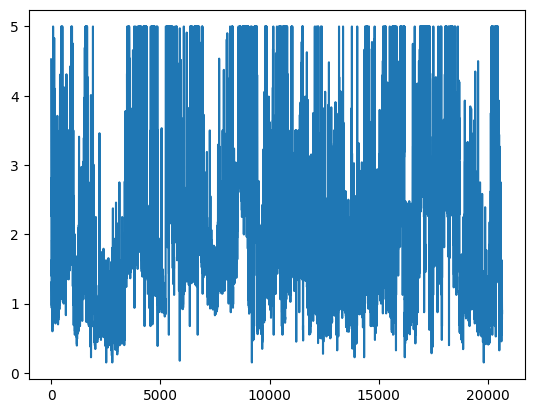

In [ ]:
# plot y
plt.plot(y)
plt.show()

In [ ]:
# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [ ]:
# check number of elements
print("Number of elements in X_train", len(X_train))
print("Number of elements in y_train", len(y_train))

print("Number of elements in X_test", len(X_test))
print("Number of elements in y_test", len(y_test))

print("len(X) = len(X_train) + len(X_test)")
print(len(X) == len(X_train) + len(X_test))

Number of elements in X_train 14447
Number of elements in y_train 14447
Number of elements in X_test 6193
Number of elements in y_test 6193
len(X) = len(X_train) + len(X_test)
True


In [ ]:
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).

n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [ ]:
# check elements in batch
print("len(batch_start) = len(X_train) // batch_size")
print(len(batch_start) == len(X_train) // batch_size)

print("--- WHY ? ----")

print(batch_start[-1])
print(batch_start[-2])
print("Length of dataset", len(X_train))

print(len(X_train) == len(batch_start) * batch_size)
print(len(X_train) == len(batch_start) * batch_size - 3)

len(batch_start) = len(X_train) // batch_size
False
--- WHY ? ----
tensor(14440)
tensor(14430)
Length of dataset 14447
False
True


In [ ]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())



Epoch 99: 100%|██████████| 1445/1445 [00:07<00:00, 194.87batch/s, mse=0.169]


MSE: 0.50
RMSE: 0.71


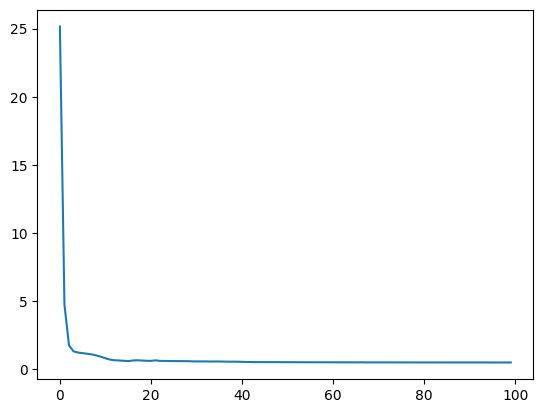

In [ ]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
# test the model
with torch.no_grad():
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    print("MSE: %.2f" % mse)

MSE: 0.50


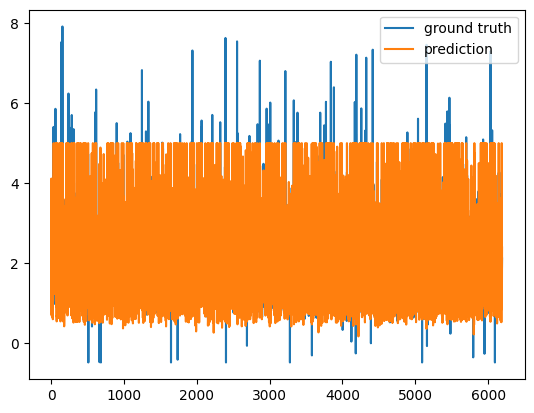

In [ ]:
# plot prediction vs ground truth
plt.plot(range(len(y_pred)), y_pred, label="ground truth")
plt.plot(range(len(y_test)), y_test, label="prediction")
plt.legend()
plt.show()
